In [1]:
import os

import torch
from hydra import compose, initialize
from torch.utils.data import DataLoader

from src.components.cdvi import load_from_cfg
from src.utils.visualize import visualize_cdvi_for_bml

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

privateuseone:0


In [3]:
dir = "../models/test"

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="config")

    cdvi, dataloader, _ = load_from_cfg(cfg, device)

    path = f"{dir}/cdvi.pth"

    if os.path.exists(path):
        state_dict = torch.load(path, map_location=torch.device("cpu"), weights_only=True)
        cdvi.load_state_dict(state_dict)
        print(f"loaded cdvi from {path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 296890.56it/s]


/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/normal.py:71: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.normal(self.loc.expand(shape), self.scale.expand(shape))


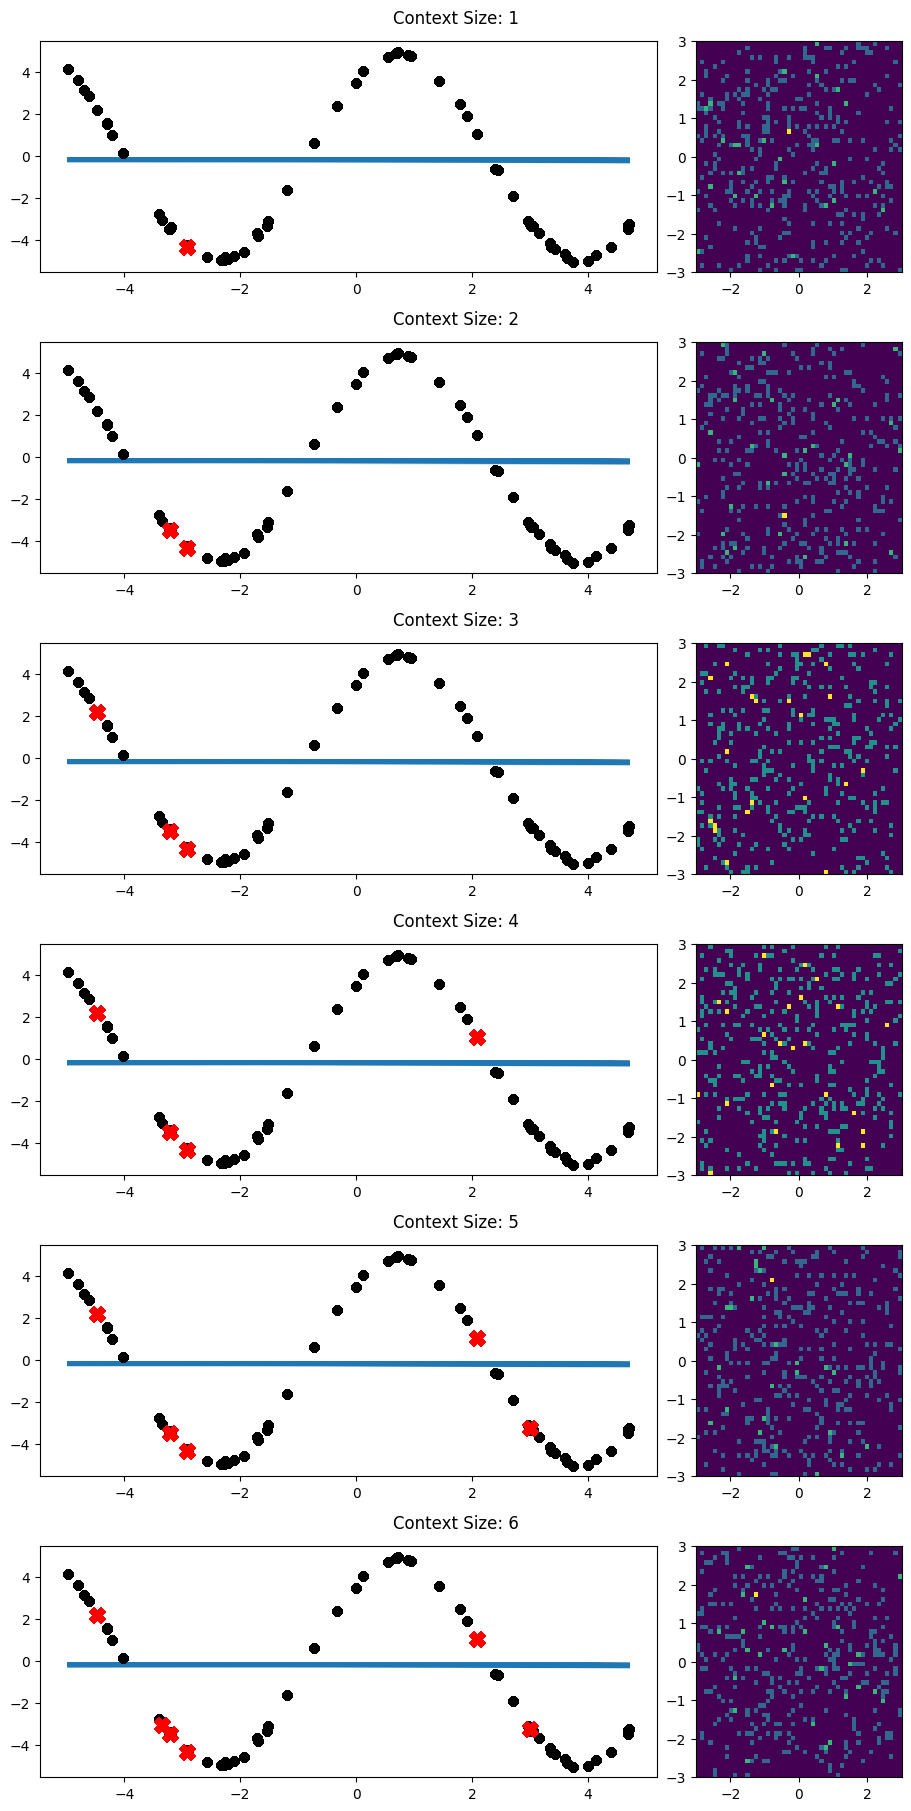

In [5]:
max_context_size = 6
num_samples = 1024
gen_dataloader = DataLoader(dataloader.dataset, 1, True)

visualize_cdvi_for_bml(
    device=device,
    cdvi=cdvi,
    dataloader=gen_dataloader,
    config=cfg,
    num_samples=num_samples,
    max_context_size=max_context_size
)